## Data Background

source : https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
    
   Data set is collected from 30 volunteers (subject attribute in cloumns) performing different activities with a smartphone attached to their waists. Activities are manually labeled into 6 classes such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying.
 
 The original 6 feature data recoreded using the Gyroscope and accelerometer in the smartphone along the x,y & z axes was used by the domian experts to build 561 new features.
 
 So we have both raw time seried data with 6 features generated from the smartphone and the feature-engineered data with 561 new features built by domian experts
 
 we will first train Machine learning models using feature engineered data and then a LSTM Based NN on the original time series data. We will compare the results of all the models in the end.
 
 
 The readings from 70% of the volunteers were taken as trianing data and remaining 30% subjects recordings were taken for test data


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import itertools
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Feature Engineered Data

In [22]:
train = pd.read_csv('UCI_HAR_Dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/csv_files/test.csv')

In [23]:
train.shape, test.shape

((7352, 564), (2947, 564))

In [24]:
train.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


### 1. Checking for the imbalances in the data

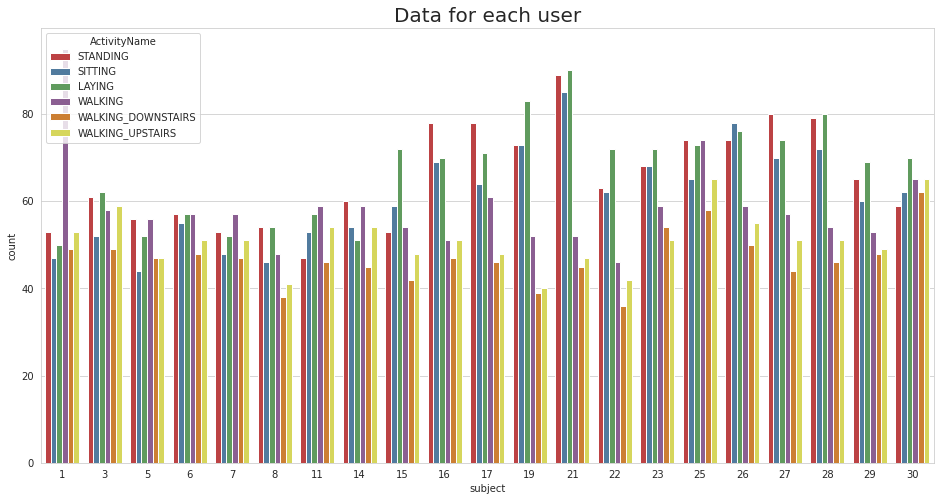

In [25]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize = (16,8))
plt.title('Data for each user', fontsize = 20)
sns.countplot(x = 'subject',hue = 'ActivityName', data = train)
plt.show()

- we have almost same number of readings from all the subjects

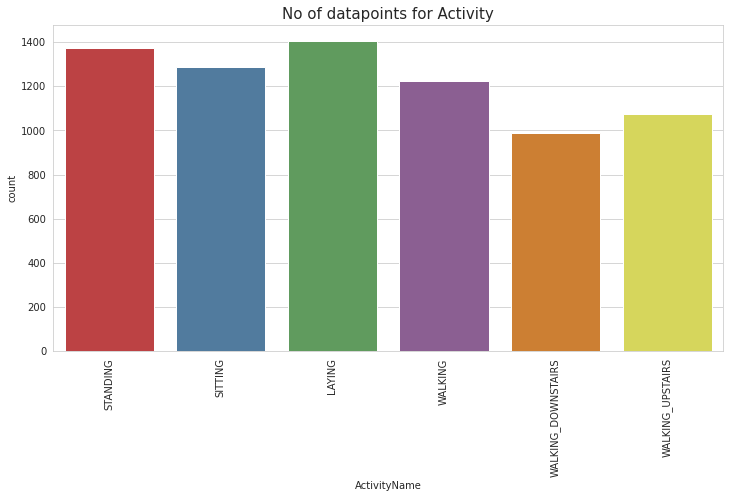

In [26]:
plt.figure(figsize = (12,6))
sns.countplot(train.ActivityName)
plt.title('No of datapoints for Activity', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()


- Data is almost balanced

### 2. Checking for Duplicates

In [27]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


### 3. Checking for NANs

In [28]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


### 4. Changing feature names 

In [29]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject', 'Activity', 'ActivityName'],
      dtype='object', length=564)

## EDA

In [30]:
import warnings
warnings.filterwarnings('ignore')

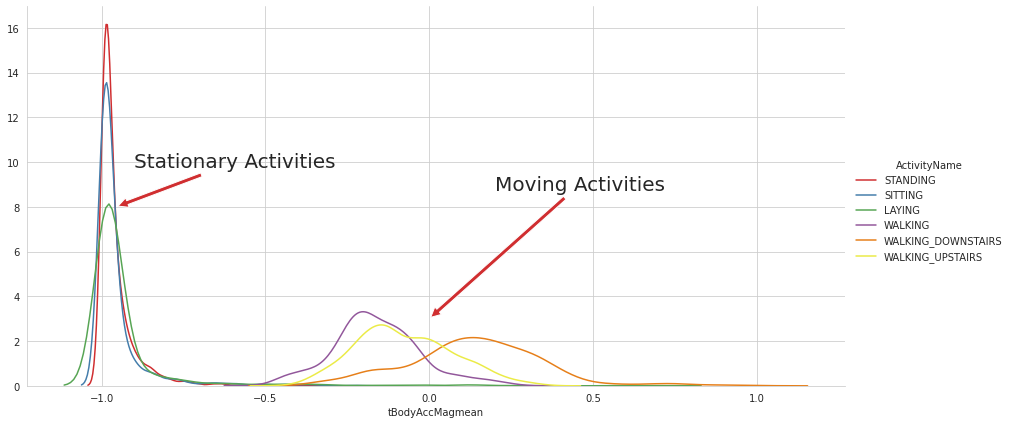

In [31]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-annotate-in-python/
sns.set_palette('Set1', desat = 0.80)
facetgrid = sns.FacetGrid(train, hue = 'ActivityName', size = 6, aspect = 2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False).add_legend()
plt.annotate('Stationary Activities',xy =(-0.956,8),
             xytext = (-0.9, 10), size=20,  va='center', ha='left', 
                arrowprops = dict(arrowstyle="simple"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple"))
plt.show()

- we can see a clear distinguishment between stationary and moving activities from the plot

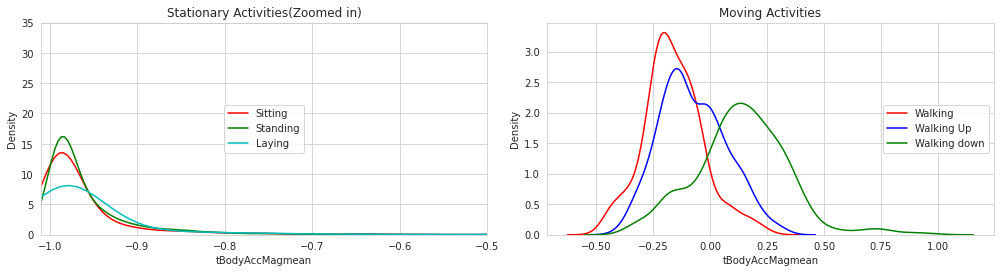

In [32]:
# for plotting purposes taking datapoints of each activity to a different dataframe
df1 = train[train['Activity']==1]
df2 = train[train['Activity']==2]
df3 = train[train['Activity']==3]
df4 = train[train['Activity']==4]
df5 = train[train['Activity']==5]
df6 = train[train['Activity']==6]

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMagmean'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMagmean'],color = 'g',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMagmean'],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.01, -0.5, 0, 35])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMagmean'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMagmean'],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMagmean'],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

####  2.Plotting Acceleration 

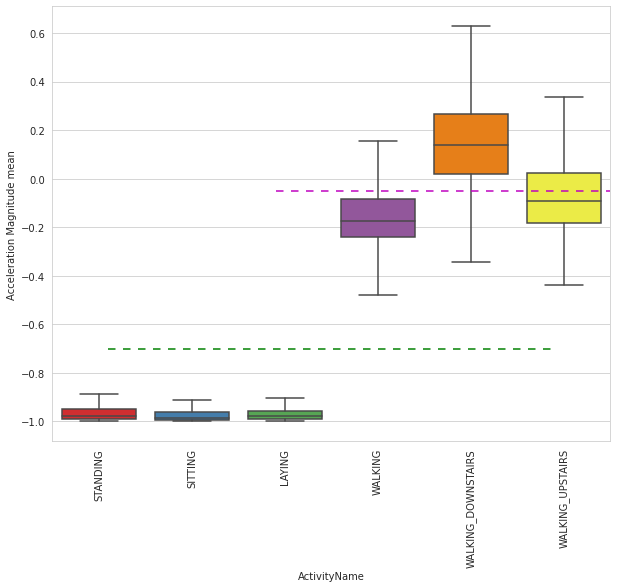

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(x='ActivityName', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

From the above plot, we can observe
- A clear seperation between stationary and active activities
- If the acceleartion mean < -0.8 then the acticity is either standing or sitting or laying
- If the acceleartion mean > -0.6 then the activity is either walking or walking downstairs or walking upstairs
- If accelearation Mean > 0.0 then the Activity is WalkingDownstairs.


#### 3. Plotting Gravity mean

#### Along the X-axis

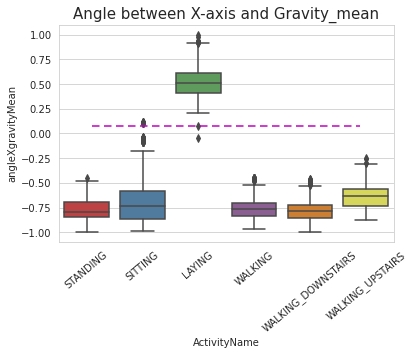

In [34]:
sns.boxplot(x='ActivityName', y='angleXgravityMean', data=train)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

- We can observe if gravity mean mean > 0 then activity is laying
- with a single if else statement we can classify all the datapoints that belongs to laying activity

#### Along the Y-axis

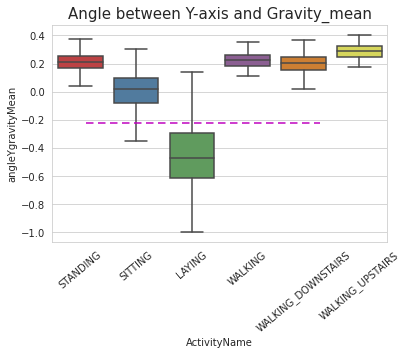

In [35]:
sns.boxplot(x='ActivityName', y='angleYgravityMean', data = train, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

## Applying T-sne

In [45]:
y_pre_tsne = train.ActivityName
X_for_tsne = train.drop(['subject', 'Activity','ActivityName'], axis = 1)


In [48]:
tsne = TSNE(perplexity= 10)
X_embedding = tsne.fit_transform(X_for_tsne)

<AxesSubplot:>

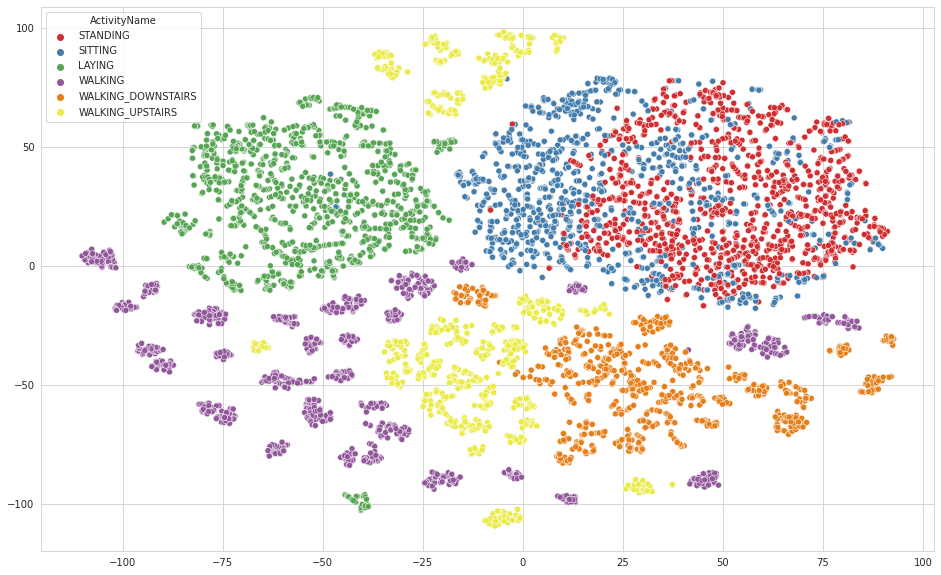

In [50]:
plt.figure(figsize = (16,10))
sns.scatterplot(x = X_embedding[:,0],y =  X_embedding[:,1],hue = y_pre_tsne)

- From the dimentionaly reduced scatter plot, we can observe that all the acitvities except standing and sitting are clearly distinguishable 

## Training ML Models

In [51]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName
X_train.shape, y_train.shape

((7352, 561), (7352,))

In [52]:
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName
X_test.shape, y_test.shape

((2947, 561), (2947,))

In [53]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [68]:
plt.rcParams["font.family"] = 'DejaVu Sans'

# Function to plot confusion matrix

def plot_confusion_matrix(cm, classes, normalize = False,
                         title = 'confusion matrix',
                         cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis =1)[:,np.newaxis]
        
    plt.imshow(cm, interpolation = 'nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [69]:
from datetime import datetime


In [70]:
#Generic function to run different models

def run_model(model, x_train,y_train,x_test,y_test, class_labels):
    
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(x_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(in Hours:Mins:Secs) - {}\n\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(x_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(Hours:Mins:Secs) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store  test accuracy in results
    results['accuracy'] = accuracy
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

### Logestic Regression with Grid Search

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   12.3s finished


Done 
 

training_time(in Hours:Mins:Secs) - 0:00:13.413564


Predicting test data
Done 
 

testing time(Hours:Mins:Secs) - 0:00:00.007069




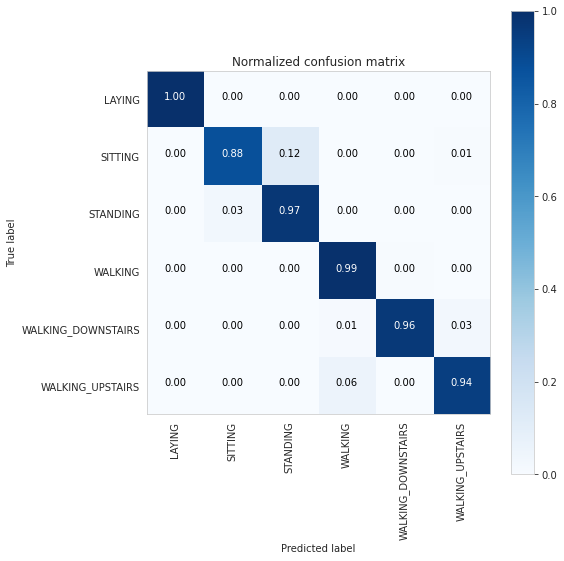

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [71]:
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1)
log_reg_grid_results =  run_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)


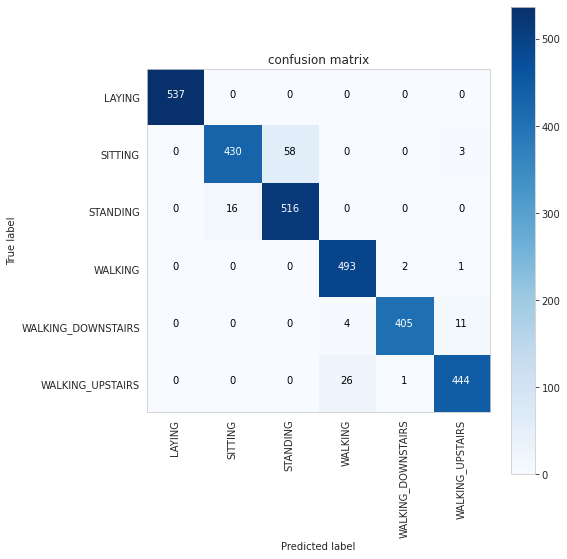

In [72]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels)
plt.show()

- We can observe that the model got confused between sitting and standing activities

In [73]:
print('Best params :',log_reg_grid.best_params_)
print('='*60)
print('Best score :',log_reg_grid.best_score_)

Best params : {'C': 1, 'penalty': 'l2'}
Best score : 0.9368895661079609


## Rbf Kernel SVM with Grid search

training the model..
Done 
 

training_time(in Hours:Mins:Secs) - 0:04:23.473538


Predicting test data
Done 
 

testing time(Hours:Mins:Secs) - 0:00:01.939368




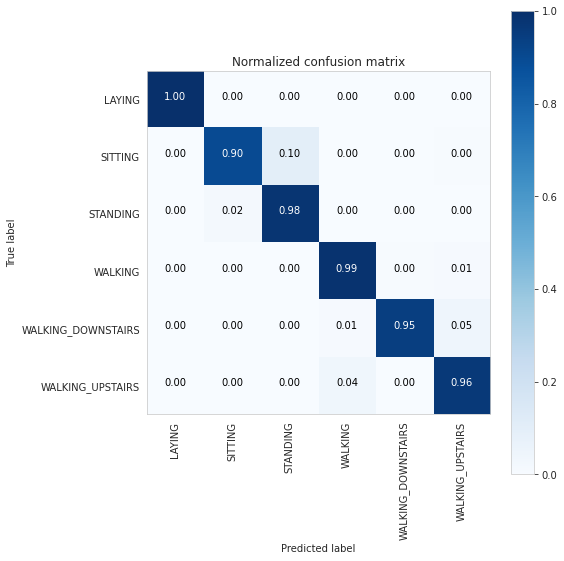

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [74]:
from sklearn.svm import SVC
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = run_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

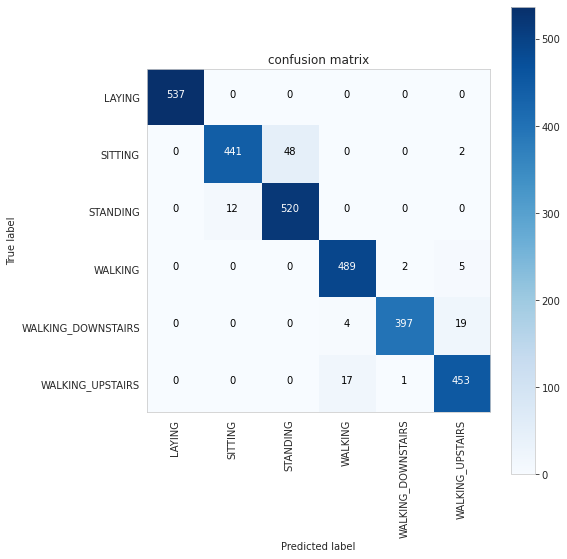

In [75]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(rbf_svm_grid_results['confusion_matrix'], classes=labels)
plt.show()

- SVM is slightly better tha Lr Reg in classifying sitting and standing

In [76]:
print('Best params :',rbf_svm_grid.best_params_)
print('='*60)
print('Best score :',rbf_svm_grid.best_score_)

Best params : {'C': 16, 'gamma': 0.0078125}
Best score : 0.9447834551903698


## Random Forest Classifier

training the model..
Done 
 

training_time(in Hours:Mins:Secs) - 0:02:55.162504


Predicting test data
Done 
 

testing time(Hours:Mins:Secs) - 0:00:00.026334




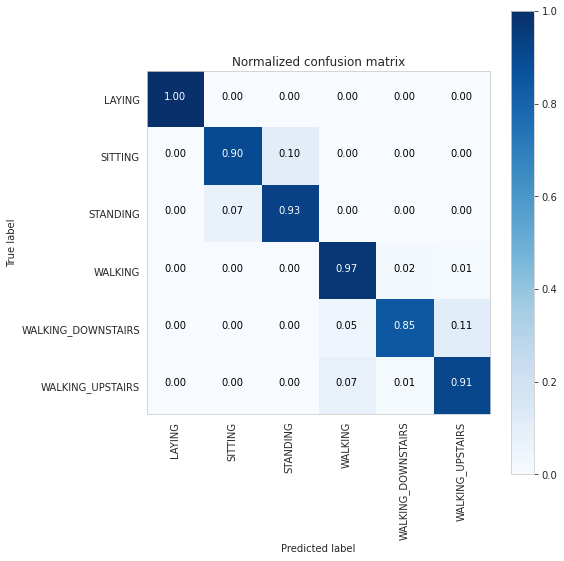

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.90      0.91       491
          STANDING       0.91      0.93      0.92       532
           WALKING       0.90      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
  WALKING_UPSTAIRS       0.89      0.91      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



In [77]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = run_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

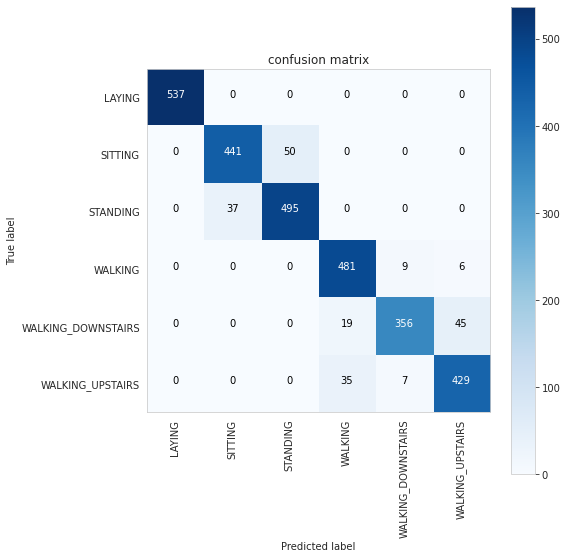

In [78]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(rfc_grid_results['confusion_matrix'], classes=labels)
plt.show()

- Rf model is making more errors comapred to lr and rbf svm in differentiating walking and walking downstairs

In [79]:
print('Best params :',rfc_grid.best_params_)
print('='*60)
print('Best score :',rfc_grid.best_score_)

Best params : {'max_depth': 13, 'n_estimators': 70}
Best score : 0.9228826704033075


## Comparision of all three ML models

In [80]:
print('\n                 Test Accuracy     Error')
print('                   --------------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))


print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))


print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))



                 Test Accuracy     Error
                   --------------   --------
Logistic Regression : 95.86%       4.14%
rbf SVM classifier  : 96.27%      3.733% 
Random Forest       : 92.94%      7.058% 


 ### Conclusions:
> Test accuracy difference between __L.R__ and __rbf SVM__ is very narrow. 
> We can choose ___Logistic regression___ or  ___rbf SVM___ as they both are performing very well. 
> If we have low latency requirement then we can choose __L.R__ over __rbf SVM__ as it is very fast.

> The features given by the experts are very powerful in classifying in label activities. Domain- Knowledge in feature-engineering matter the most in finding best model for a given problem

# Orginal Time-series Data

## Training a LSTM Model

In [118]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [119]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [82]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [106]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 
    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [110]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [111]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [112]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [114]:
X_train.shape, X_test.shape

((7352, 128, 9), (2947, 128, 9))

In [117]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

In [124]:
# Import Keras
from tensorflow.compat.v1.keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [125]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [126]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [129]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape = (timesteps,input_dim)))
model.add(Dropout(0.5)) # adding a drop out layer
model.add(Dense(n_classes, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5376      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [130]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [131]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 8s 18ms/step - loss: 1.3322 - accuracy: 0.4576 - val_loss: 1.1440 - val_accuracy: 0.5110
Epoch 2/30
460/460 [==============================] - 8s 16ms/step - loss: 1.0121 - accuracy: 0.5661 - val_loss: 0.9824 - val_accuracy: 0.5786
Epoch 3/30
460/460 [==============================] - 8s 16ms/step - loss: 0.8021 - accuracy: 0.6402 - val_loss: 0.8120 - val_accuracy: 0.6315
Epoch 4/30
460/460 [==============================] - 7s 16ms/step - loss: 0.7070 - accuracy: 0.6722 - val_loss: 0.7601 - val_accuracy: 0.6793
Epoch 5/30
460/460 [==============================] - 7s 16ms/step - loss: 0.6534 - accuracy: 0.7137 - val_loss: 0.6650 - val_accuracy: 0.7323
Epoch 6/30
460/460 [==============================] - 7s 16ms/step - loss: 0.5771 - accuracy: 0.7855 - val_loss: 1.0942 - val_accuracy: 0.6834
Epoch 7/30
460/460 [==============================] - 7s 16ms/step - loss: 0.5081 - accuracy: 0.8341 - val_loss: 0.6399 - val_accuracy: 0.8049

In [133]:
model.predict(X_test)

array([[5.6838580e-05, 6.3270236e-05, 5.5009750e-06, 1.1803359e-02,
        7.0451277e-01, 4.3200860e-05],
       [6.2184918e-05, 5.5822740e-05, 5.7789430e-06, 1.1361450e-02,
        6.7920184e-01, 2.5974225e-05],
       [6.4568296e-05, 5.7108511e-05, 5.7727407e-06, 1.1380345e-02,
        6.7707384e-01, 2.5856065e-05],
       ...,
       [4.3058870e-05, 9.2246640e-01, 1.9335023e-06, 2.1142285e-05,
        3.5647508e-06, 2.2240565e-09],
       [2.7422895e-05, 9.2038095e-01, 2.3703574e-06, 1.5776972e-05,
        3.6878055e-06, 1.6342461e-09],
       [2.0950883e-05, 9.1319263e-01, 1.1037555e-06, 2.0506350e-05,
        2.6664015e-06, 9.6518504e-10]], dtype=float32)

In [136]:
def return_labels(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return Y_true, Y_pred

In [138]:
Y_true, Y_pred = return_labels(Y_test, model.predict(X_test))

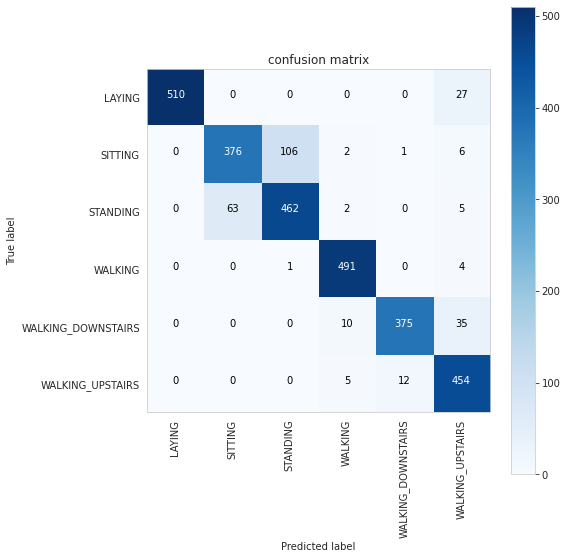

In [140]:
cm = metrics.confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=labels)
plt.show()

In [141]:
score = model.evaluate(X_test, Y_test)
score

93/93 [==============================] - 0s 4ms/step - loss: 0.4358 - accuracy: 0.9053


[0.43582361936569214, 0.9053274393081665]

9.467256099999998

- Using a simple 2-layer architecture of LSTM with out hyperparameter tuning, we got test accuracy of 90.09 and loss of 0.43 and error percentage of 9.46 which is on par with the random forest model trained on expert featured engineered data.

Comparision of ML models with LSTM Model

In [148]:
print('\n                 Test Accuracy     Error')
print('                   --------------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))


print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))


print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('LSTM Model          : {:.04}%      {:.04}% '.format(score[1] * 100,\
                                                           100-(score[1] * 100)))


                 Test Accuracy     Error
                   --------------   --------
Logistic Regression : 95.86%       4.14%
rbf SVM classifier  : 96.27%      3.733% 
Random Forest       : 92.94%      7.058% 
LSTM Model          : 90.53%      9.467% 


# Summary

- Domain understanding is really important for feature engineering and data pre-processing for Machine learning models. So when we have domian expertise and have less resources for building a model, we should prefer a ML based Model.

- In Neuralnets we can still create very powerful models without having to deeply understand the data. so when we have good computational resources and not enough knowledge in the domain, its benefitial to use a DL model